In [8]:
import os
import gym
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions.categorical import Categorical
from gym.wrappers import RecordVideo

In [9]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]
        return np.array(self.states), np.array(self.actions), np.array(self.probs), \
               np.array(self.vals), np.array(self.rewards), np.array(self.dones), batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

In [10]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha, fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/ppo'):
        super(ActorNetwork, self).__init__()
        if not os.path.exists(chkpt_dir):
            os.makedirs(chkpt_dir)
        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        self.actor = nn.Sequential(
            nn.Linear(*input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, n_actions),
            nn.Softmax(dim=-1)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        return dist

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

In [11]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/ppo'):
        super(CriticNetwork, self).__init__()
        if not os.path.exists(chkpt_dir):
            os.makedirs(chkpt_dir)
        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
            nn.Linear(*input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, 1)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)
        return value

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

In [12]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, policy_clip=0.2, 
                 batch_size=64, N=2048, n_epochs=10, gae_lambda=0.95):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_actions = n_actions
        self.gae_lambda = gae_lambda
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
        self.actor_losses = []
        self.critic_losses = []
        self.total_losses = []

    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()
        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()
        return action, probs, value

    def learn(self):
        actor_loss_sum = 0
        critic_loss_sum = 0
        total_loss_sum = 0

        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr, reward_arr, dones_arr, batches = \
                self.memory.generate_batches()
            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*(1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t

            advantage = T.tensor(advantage).to(self.actor.device)
            values = T.tensor(values).to(self.actor.device)

            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)
                critic_value = T.squeeze(critic_value)
                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip, 1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns - critic_value)**2
                critic_loss = critic_loss.mean()
                total_loss = actor_loss + 0.5*critic_loss

                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

                actor_loss_sum += actor_loss.item()
                critic_loss_sum += critic_loss.item()
                total_loss_sum += total_loss.item()

        self.actor_losses.append(actor_loss_sum / self.n_epochs)
        self.critic_losses.append(critic_loss_sum / self.n_epochs)
        self.total_losses.append(total_loss_sum / self.n_epochs)
        self.memory.clear_memory()

In [13]:
def plot_learning_curve(x, scores, avg_scores, actor_losses, critic_losses, total_losses, figure_file):
    if not os.path.exists('tmp/plots'):
        os.makedirs('tmp/plots')
    actor_len = len(actor_losses)
    actor_len = np.arange(actor_len)
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    
    axs[0, 0].plot(x, scores, label="Episode Scores")
    axs[0, 0].set_title("Episode Scores")
    axs[0, 0].set_xlabel("Episode")
    axs[0, 0].set_ylabel("Score")
    
    axs[0, 1].plot(x, avg_scores, label="Average Scores (last 100)")
    axs[0, 1].set_title("Running Average Scores")
    axs[0, 1].set_xlabel("Episode")
    axs[0, 1].set_ylabel("Average Score")
    
    axs[0, 2].plot(actor_len, actor_losses, label="Actor Loss")
    axs[0, 2].set_title("Actor Network Loss")
    axs[0, 2].set_xlabel("Actor Updates Length")
    axs[0, 2].set_ylabel("Loss")
    
    axs[1, 0].plot(actor_len, critic_losses, label="Critic Loss")
    axs[1, 0].set_title("Critic Network Loss")
    axs[1, 0].set_xlabel("Episode")
    axs[1, 0].set_ylabel("Actor Updates Length")
    
    axs[1, 1].plot(actor_len, total_losses, label="Total Loss")
    axs[1, 1].set_title("Combined Loss")
    axs[1, 1].set_xlabel("Actor/Critic Updates Length")
    axs[1, 1].set_ylabel("Loss")
    
    plt.tight_layout()
    plt.savefig(figure_file)

c:\Users\pc\.conda\envs\RL\lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at c:\Users\pc\Documents\Masters\erasmus\emai\1st Year\1st Semester\Reinforcement Learning\project\ppo\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building video c:\Users\pc\Documents\Masters\erasmus\emai\1st Year\1st Semester\Reinforcement Learning\project\ppo\videos\rl-video-episode-0.mp4.
MoviePy - Writing video c:\Users\pc\Documents\Masters\erasmus\emai\1st Year\1st Semester\Reinforcement Learning\project\ppo\videos\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready c:\Users\pc\Documents\Masters\erasmus\emai\1st Year\1st Semester\Reinforcement Learning\project\ppo\videos\rl-video-episode-0.mp4
... saving models ...
Episode 1 | Score: 55.0 | Avg Score: 55.0 | Steps: 55 | Actor Loss: -27.2569 | Critic Loss: 203.5713 | Total Loss: 74.5288
Episode 2 | Score: 23.0 | Avg Score: 39.0 | Steps: 78 | Actor Loss: -23.7081 | Critic Loss: 154.4860 | Total Loss: 53.5349
Episode 3 | Score: 33.0 | Avg Score: 37.0 | Steps: 111 | Actor Loss: -25.7301 | Critic Loss: 157.6300 | Total Loss: 53.0849
Episode 4 | Score: 22.0 | Avg Score: 33.2 | Steps: 133 | Actor Loss: -15.8086 | Critic Loss: 53.0922 | Total Loss: 10.7375
Episode 5 | Score: 13.0 | Avg Score: 29.2 | Steps: 146 | Actor Loss: -14.8800 | Critic Loss: 60.6468 | Total Loss: 15.4434
Episode 6 | Score: 51.0 | Avg Score: 32.8 | Steps: 197 | Actor Loss: -25.4780 | Critic Loss: 130.0575 | Total Loss: 39.5508
Episode 7 | Score: 28.0 | Avg Score: 32.1 | Steps: 225 | Actor Loss: 

MoviePy - Done !
MoviePy - video ready c:\Users\pc\Documents\Masters\erasmus\emai\1st Year\1st Semester\Reinforcement Learning\project\ppo\videos\rl-video-episode-100.mp4
Episode 101 | Score: 205.0 | Avg Score: 99.6 | Steps: 10018 | Actor Loss: 0.6542 | Critic Loss: 0.5483 | Total Loss: 0.9284
Episode 102 | Score: 500.0 | Avg Score: 104.4 | Steps: 10518 | Actor Loss: -11.5407 | Critic Loss: 18.7812 | Total Loss: -2.1501
Episode 103 | Score: 42.0 | Avg Score: 104.5 | Steps: 10560 | Actor Loss: -3.2291 | Critic Loss: 22.2365 | Total Loss: 7.8891
Episode 104 | Score: 146.0 | Avg Score: 105.7 | Steps: 10706 | Actor Loss: -7.4166 | Critic Loss: 13.3480 | Total Loss: -0.7427
Episode 105 | Score: 118.0 | Avg Score: 106.8 | Steps: 10824 | Actor Loss: -1.5970 | Critic Loss: 0.8757 | Total Loss: -1.1592
Episode 106 | Score: 142.0 | Avg Score: 107.7 | Steps: 10966 | Actor Loss: -8.3077 | Critic Loss: 16.8918 | Total Loss: 0.1382
Episode 107 | Score: 66.0 | Avg Score: 108.1 | Steps: 11032 | Actor 

MoviePy - Done !
MoviePy - video ready c:\Users\pc\Documents\Masters\erasmus\emai\1st Year\1st Semester\Reinforcement Learning\project\ppo\videos\rl-video-episode-200.mp4
... saving models ...
Episode 201 | Score: 500.0 | Avg Score: 386.8 | Steps: 48700 | Actor Loss: -0.0201 | Critic Loss: 0.0008 | Total Loss: -0.0198
Episode 202 | Score: 500.0 | Avg Score: 386.8 | Steps: 49200 | Actor Loss: -0.0679 | Critic Loss: 0.0022 | Total Loss: -0.0668
... saving models ...
Episode 203 | Score: 500.0 | Avg Score: 391.4 | Steps: 49700 | Actor Loss: -0.0105 | Critic Loss: 0.0026 | Total Loss: -0.0092
... saving models ...
Episode 204 | Score: 500.0 | Avg Score: 394.9 | Steps: 50200 | Actor Loss: -0.0904 | Critic Loss: 0.0011 | Total Loss: -0.0898


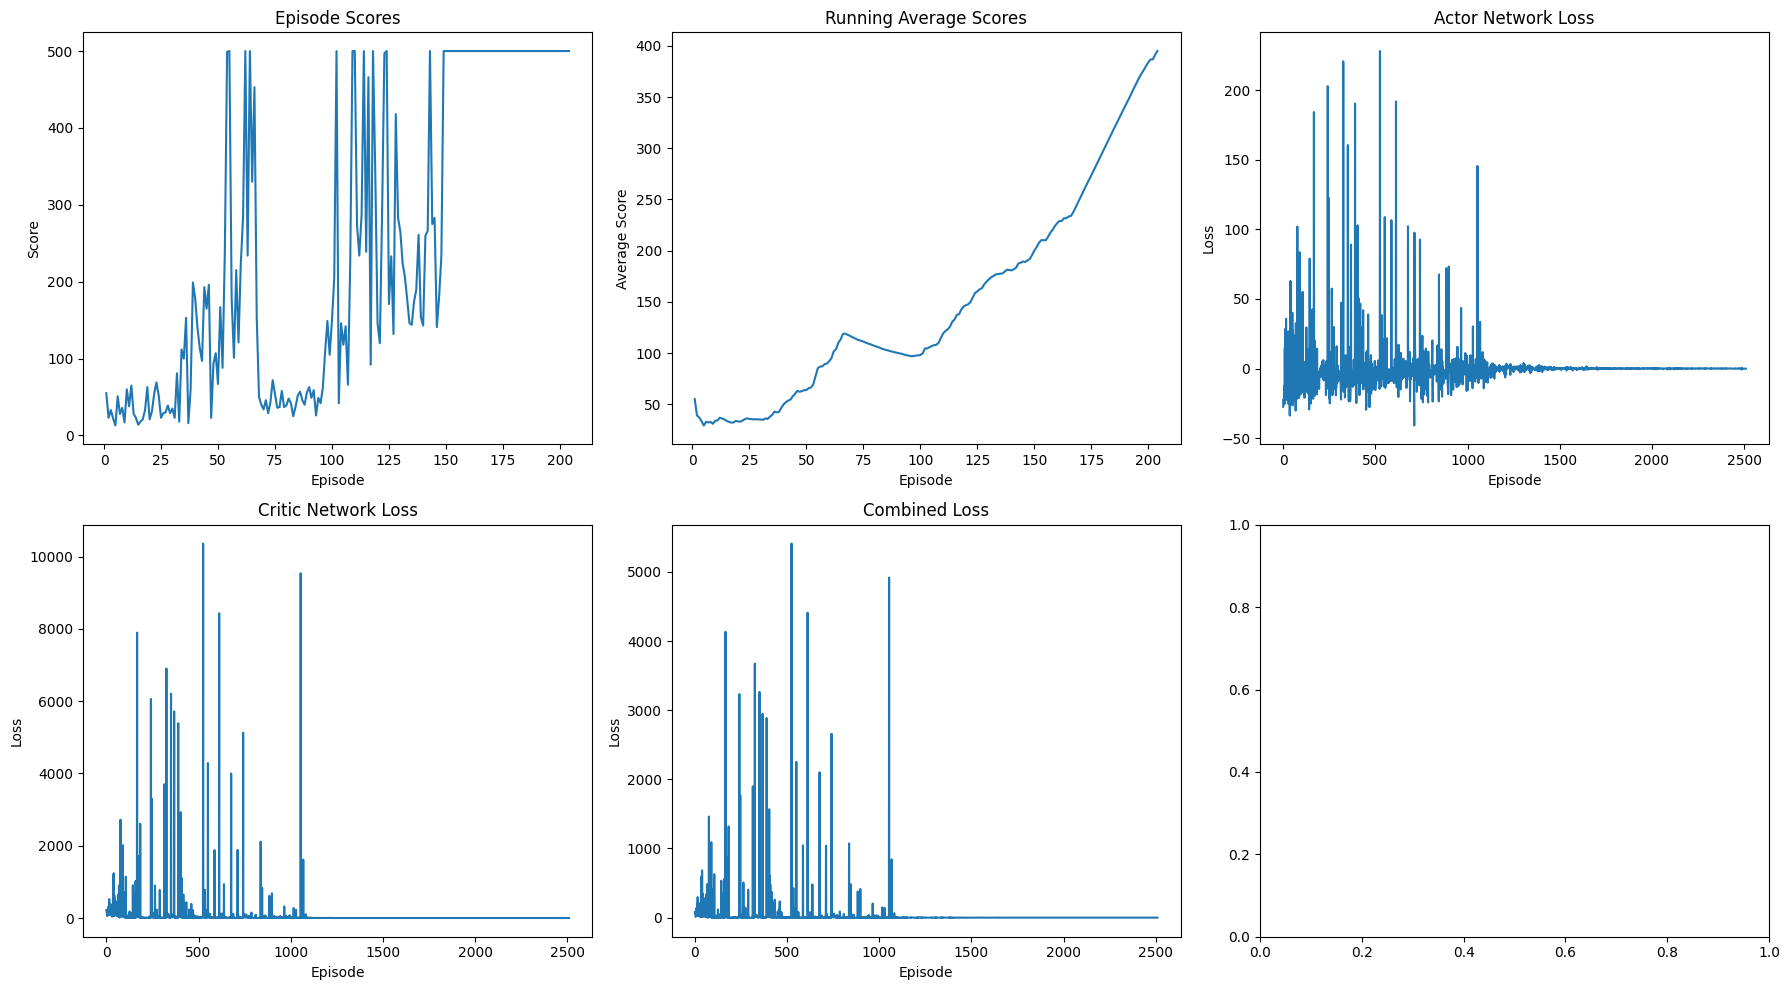

In [14]:
if __name__ == '__main__':
    video_path = 'tmp/videos/'
    if not os.path.exists(video_path):
        os.makedirs(video_path)

    env = gym.make('CartPole-v1', render_mode='rgb_array')
    env = gym.wrappers.RecordVideo(env, video_path, episode_trigger=lambda episode_id: episode_id % 100 == 0)

    N = 20
    batch_size = 5
    n_epochs = 4
    alpha = 0.0003
    total_steps = 50000

    obs_shape = env.observation_space.shape
    input_dims = obs_shape if len(obs_shape) != 0 else (env.observation_space.n,)

    agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, 
                  alpha=alpha, input_dims=input_dims, n_epochs=n_epochs)

    figure_file = 'tmp/plots/cartpole.png'
    best_score = env.reward_range[0]
    score_history = []
    avg_score_history = []
    returns_history = []
    episode_lengths = []

    learn_iters = 0
    n_steps = 0

    while n_steps < total_steps:
        obs, _ = env.reset()
        done = False
        score = 0
        episode_returns = 0
        episode_length = 0

        while not done:
            action, prob, val = agent.choose_action(obs)
            observation_, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            n_steps += 1
            episode_length += 1
            score += reward
            episode_returns += reward
            agent.remember(obs, action, prob, val, reward, done)

            if n_steps % N == 0:
                agent.learn()
                learn_iters += 1

            obs = observation_

        score_history.append(score)
        returns_history.append(episode_returns)
        episode_lengths.append(episode_length)
        avg_score = np.mean(score_history[-100:])
        avg_score_history.append(avg_score)

        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()

        print(f"Episode {len(score_history)} | Score: {score:.1f} | Avg Score: {avg_score:.1f} | "
                    f"Steps: {n_steps} | Actor Loss: {agent.actor_losses[-1]:.4f} | "
                    f"Critic Loss: {agent.critic_losses[-1]:.4f} | "
                    f"Total Loss: {agent.total_losses[-1]:.4f}")

    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, avg_score_history, 
                       agent.actor_losses, agent.critic_losses, 
                       agent.total_losses, figure_file)

    env.close()

In [15]:
def test_model(env, num_episodes=10):
    agent = Agent(n_actions=env.action_space.n, input_dims=env.observation_space.shape)
    agent.load_models()
    
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        score = 0
        episode_length = 0
        
        while not done:
            action, _, _ = agent.choose_action(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            score += reward
            episode_length += 1
        
        print(f"Test Episode {episode + 1}: Score = {score}, Length = {episode_length}")

if __name__ == '__main__':
    env = gym.make('CartPole-v1', render_mode='human')
    test_model(env)
    env.close()

... loading models ...


C:\Users\pc\AppData\Local\Temp\ipykernel_31924\1819442843.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(T.load(self.checkpoint_file))
C:\Users\pc

Test Episode 1: Score = 500.0, Length = 500
Test Episode 2: Score = 500.0, Length = 500
Test Episode 3: Score = 500.0, Length = 500
Test Episode 4: Score = 500.0, Length = 500
Test Episode 5: Score = 500.0, Length = 500
Test Episode 6: Score = 500.0, Length = 500
Test Episode 7: Score = 500.0, Length = 500
Test Episode 8: Score = 500.0, Length = 500
Test Episode 9: Score = 500.0, Length = 500
Test Episode 10: Score = 500.0, Length = 500
